In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import scanpy as sc
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from tqdm import tqdm

from simple_Linear_model import simple_linear

from model.stDiff_model import DiT_stDiff

/home/hanyuji/miniconda3/envs/DYffusion/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# data = torch.Tensor(np.random.random((32,40)))
# t = torch.Tensor(np.ones((1,)))

gene_num = 50
depth = 6 
hidden_size = 512 
head = 16


model = DiT_stDiff(
    input_size=gene_num*2,
    output_size=gene_num,
    hidden_size=hidden_size,
    depth=depth,
    num_heads=head,
    classes=6, 
    dit_type='dit',
    mlp_ratio=4.0,
)


In [4]:
dataset_path = '/home/hanyuji/Results/VAE_result/DR_latent_50.pkl'

with open(dataset_path, 'rb') as f:
    data_list = pickle.load(f)

label_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [5]:
def CombinationDataloader(data_list, label_list):
    combinations = []  # 存储所有可能的三点组合
    combinations_label = []

    # 生成所有可能的三点组合
    for i in range(len(data_list)):
        for j in range(i + 1, len(data_list)):
            for k in range(j + 1, len(data_list)):
                combinations.append((data_list[i], data_list[j], data_list[k]))
                combinations_label.append((label_list[i], label_list[j], label_list[k]))

    return (combinations, combinations_label)

In [6]:
combinations, combinations_label = CombinationDataloader(data_list,label_list)

In [7]:
import geomloss

def SinkhornLoss(t_true, t_est, blur=0.05, scaling=0.5):
    ot_solver = geomloss.SamplesLoss("sinkhorn", p=2, blur=blur, scaling=scaling, debias=True, backend="tensorized")
    loss = ot_solver(t_true, t_est)

    return loss

In [8]:
lr = 1e-4
device=torch.device('cuda:1')
num_epoch = 1400
criterion = SinkhornLoss
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0)

In [9]:
loss_log = []

input_size = 50
batch_size = 256

t_epoch = tqdm(range(num_epoch), ncols=100)

model.train()
for epoch in t_epoch:
    epoch_loss = 0.0
    for i, (c, l) in enumerate(zip(combinations, combinations_label)):

        c0, c1, c2 = c[0], c[1], c[2]
        
        cell_idx_0 = np.random.choice(np.arange(c0.shape[0]), size = batch_size, replace = (c0.shape[0] < batch_size))
        cell_idx_1 = np.random.choice(np.arange(c1.shape[0]), size = batch_size, replace = (c1.shape[0] < batch_size))
        cell_idx_2 = np.random.choice(np.arange(c2.shape[0]), size = batch_size, replace = (c2.shape[0] < batch_size))
        c0 = c0[cell_idx_0, :]
        c1 = c1[cell_idx_1, :]
        c2 = c2[cell_idx_2, :]
        
        x13 = np.concatenate([c0, c2], axis=1) # batchsize, 100
        x13, x2 = (
            torch.tensor(x13).type(torch.float32).to(device),
            torch.tensor(c1).type(torch.float32).to(device),
        )
        
        t = (l[1]-l[0])/(l[2]-l[0])
        t = torch.tensor(np.full(c0.shape[0], t)).type(torch.float32).to(device)
        
       
        x2_pred = model(x13, t=t)


        
        # print(f'x2.size():{x2.size()}')
        # print(f'x2_pred.size():{x2_pred.size()}')
        
        
        
        loss = criterion(x2, x2_pred)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # type: ignore
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss / (i + 1)  # type: ignore

    loss_log.append(epoch_loss)
    t_epoch.set_postfix_str(f'loss:{epoch_loss:.5f}')  # type: ignore

 29%|████████████▎                              | 402/1400 [56:12<2:19:33,  8.39s/it, loss:18.59899]


KeyboardInterrupt: 

In [22]:
model_path = '/home/hanyuji/Results/scDYff/' + 'model_interpolation_0604_402epoch_56min.pt'


torch.save(model.state_dict(), model_path)

# model.load_state_dict(torch.load(model_path))

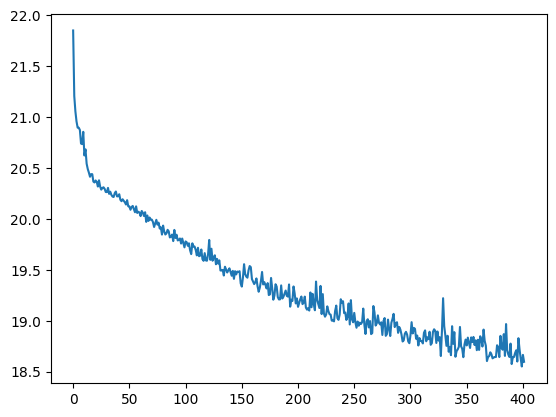

In [11]:
import matplotlib.pyplot as plt

plt.plot(loss_log)



In [20]:
batch_size=1024
data1 = data_list[0]
data2 = data_list[1]
cell_idx_0 = np.random.choice(np.arange(data1.shape[0]), size = batch_size, replace = (data1.shape[0] < batch_size))
cell_idx_0 = np.random.choice(np.arange(data2.shape[0]), size = batch_size, replace = (data2.shape[0] < batch_size))

data1 = data1[cell_idx_0, :]
data2 = data2[cell_idx_0, :]

data1 = torch.Tensor(data1)
data2 = torch.Tensor(data2)


In [21]:
SinkhornLoss(data1,data2)

tensor(26.1657)